## Get recent tweets from 145 famous investors on Twitter

The Best Invsting Blogs of 2017
https://thecollegeinvestor.com/15601/the-best-investing-blogs/

17 Venture Capital and Angel Investors to Follow on Twitter
https://www.inc.com/larry-kim/17-venture-capital-and-angel-investors-to-follow-on-twitter.html

Nine Twitter Accounts For Aspiring Real Estate Investors To Follow
https://www.forbes.com/sites/forbesrealestatecouncil/2017/05/03/9-twitter-accounts-for-aspiring-real-estate-investors-to-follow/#61c1f6a627a0

10 VCs & Angel Investors to Follow on Twitter
http://www.techinsurance.com/blog/business-tips/10-vcs-angel-investors-to-follow-on-twitter/

These Are The Top 20 Tech Investors You Should Follow On Twitter
http://www.businessinsider.com/top-20-tech-investors-on-twitter-2013-5?op=1

Top 50 Investors on Twitter and How To Engage Them
http://startupfundraising.com/top-50-investors-on-twitter-and-how-to-engage-them/

In [1]:
import pandas as pd
import numpy as np

In [2]:
import tweepy
import os

In [3]:
consumer_key = os.environ["TWITTER_CONSUMER_KEY"]
consumer_secret = os.environ["TWITTER_CONSUMER_SECRET"]
access_token = os.environ["TWITTER_ACCESS_TOKEN"]
access_token_secret = os.environ["TWITTER_TOKEN_SECRET"]

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
text_file = open("Investors_on_twitter.txt", "r")
user_list = text_file.readlines()

In [4]:
for index, user in enumerate(user_list):
    user_list[index]= user.rstrip('\n')

In [5]:
len(user_list)

143

In [7]:
from pymongo import MongoClient
client = MongoClient()
investor_tweets_db = client.investor_tweets_db
tweets_cl = investor_tweets_db.tweets_cl

In [31]:
def get_all_tweets(screen_name):
    '''get all tweets for one user'''
    #initialize a list to hold all the tweepy Tweets
    alltweets = []	

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended')

    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        #print ("getting tweets before %s" % (oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest, tweet_mode='extended')

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

    print ("{}: {} tweets downloaded so far".format(screen_name, len(alltweets)))
    return alltweets

In [ ]:
for user in user_list[114:]:
    print(user)
    if tweets_cl.find({'user': user}).count() > 0:
        continue
    all_tweets_raw = get_all_tweets(user)
    all_tweets = ''
    for tweet in all_tweets_raw:
        all_tweets += tweet.full_text + ' '
    user_dict = {}
    user_dict['user'] = user
    user_dict['all_tweets_raw'] = all_tweets
    tweets_cl.insert_one((user_dict))

In [8]:
tweets_cl.count()

143

## Clean Tweets

In [63]:
import re
import sys
import unicodedata
from string import digits

In [64]:
import html

In [65]:
for investor in tweets_cl.find({}):
    all_tweets_clean = html.unescape(investor['all_tweets_raw']) #convert html entities to string
    all_tweets_clean = ''.join(c for c in unicodedata.normalize('NFC', all_tweets_clean) if c <= '\uFFFF') #remove emojis
    all_tweets_clean = re.sub('(%)|(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)|(^rt)|(^RT)|(^Rt)|(\sRT\s)|(\sRt\s)|(\srt\s)|(http.+?)', ' ', all_tweets_clean).strip() #remove %, @, https, RT 
    all_tweets_clean = re.sub('\s+', ' ', all_tweets_clean) #remove multiple spaces
    all_tweets_clean = ''.join([i for i in all_tweets_clean if not i.isdigit()]) #remove all digits
    tweets_cl.update_one({"_id": investor["_id"]}, {"$set": {"all_tweets_clean": all_tweets_clean}}) 

## Natural Language Processing

In [9]:
import spacy

In [10]:
nlp = spacy.load('en')

In [72]:
for investor in tweets_cl.find({}):
    doc = nlp(investor['all_tweets_clean'])
    bag_of_words = ''
    for token in doc:
        if token.is_stop or token.is_space or token.is_punct or token.is_digit or token.like_num:
            continue
        elif token.is_ascii:
            bag_of_words += token.lemma_ + ' '
        else:
            continue
    tweets_cl.update_one({"_id": investor["_id"]}, {"$set": {"bag_of_words": bag_of_words}})

In [11]:
tweets_cl.find_one({'user' : '5_min_macro'})['all_tweets_raw'][:1000]

"@PlanMaestro What if the BK ignores the Nf8, and heads for e5? Nd7 Kc7, Nf8 Kd6, Kf4 Kd5 etc @offbalancetweet Possible, but the way the story reads, I'd lean towards my guess, also given what we know about Tesla's addiction to hype. Tesla comped bond investors an extra 5 bp after books had closed; presume so that bond wouldn't trade below par. https://t.co/e1HsWHyjMi Per the age-old Rothschild maxim, buy on the firing of Bannons. Fed policy can squeeze inflation from eg 4% to 2%. Patently ridiculous to clamour for policy that can move inflation from, say, 1.5% to 2%. Much shrill mkt comment abt small inflation divergences. There's no economic difference btwn 1.5% inflation and 2%, and no way of tweaking. Next mkt correction, S&amp;P loses 40% in 5 mins before snapping back. Poorly timed bathroom break, u miss the generational buying opportunity. We don't even know what Trump's team will look like next week, but people are speculating about the next Fed Chair. 'How cd Gary Cohn?'\nCos 

In [12]:
tweets_cl.find_one({'user' : '5_min_macro'})['all_tweets_clean'][:1000]

"What if the BK ignores the Nf, and heads for e? Nd Kc, Nf Kd, Kf Kd etc Possible, but the way the story reads, I'd lean towards my guess, also given what we know about Tesla's addiction to hype. Tesla comped bond investors an extra  bp after books had closed; presume so that bond wouldn't trade below par. Per the age-old Rothschild maxim, buy on the firing of Bannons. Fed policy can squeeze inflation from eg  to  . Patently ridiculous to clamour for policy that can move inflation from, say, . to  . Much shrill mkt comment abt small inflation divergences. There's no economic difference btwn . inflation and  , and no way of tweaking. Next mkt correction, S&P loses  in  mins before snapping back. Poorly timed bathroom break, u miss the generational buying opportunity. We don't even know what Trump's team will look like next week, but people are speculating about the next Fed Chair. 'How cd Gary Cohn?' Cos u don't reach the top of the slippery pole at a bulge bracket IB w/o sloughing remn

In [13]:
tweets_cl.find_one({'user' : '5_min_macro'})['bag_of_words'][:1000]

"bk ignore nf head e nd kc nf kd kf kd possible way story read would lean guess give know tesla 's addiction hype tesla comp bond investor extra bp book close presume bond not trade par age old rothschild maxim buy firing bannons fed policy squeeze inflation eg patently ridiculous clamour policy inflation shrill mkt comment abt small inflation divergence be economic difference btwn inflation way tweak mkt correction s&p lose min snap poorly time bathroom break u mis generational buying opportunity not know trump 's team look like week people speculate fed chair cd gary cohn cos u not reach slippery pole bulge bracket ib w o sloughing remnant humanity way try adopt world weary man say surprise shock stance turn strategy form washington redskins change negative association henceforth know maryland redskins be uzi katz fugitive justice change oozi cats like totally legit strategy number 's opioid epidemic insane m americans prescription painkiller non facetious answer enjoy piece + feel g

## CountVectorizer

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from pymongo import MongoClient
client = MongoClient()
investor_tweets_db = client.investor_tweets_db
tweets_cl = investor_tweets_db.tweets_cl

In [3]:
text_file = open("Investors_on_twitter.txt", "r")
user_list = text_file.readlines()

In [4]:
for index, user in enumerate(user_list):
    user_list[index]= user.rstrip('\n')

In [5]:
corpus = []

In [6]:
for user in user_list:
    corpus.append(tweets_cl.find_one({'user': user})['bag_of_words'])

In [7]:
vectorizer = CountVectorizer()

In [8]:
X = vectorizer.fit_transform(corpus)

In [9]:
word_list = vectorizer.get_feature_names()

In [10]:
len(word_list)

88311

## SVD

In [12]:
from sklearn.decomposition import TruncatedSVD

In [13]:
import numpy as np
import pandas as pd

In [14]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=81917)
svd.fit(X)
X_reduced = svd.transform(X)
print(svd.explained_variance_ratio_) 

[ 0.06286803  0.11469865  0.06917459  0.06601118  0.05173068  0.04983679
  0.04124244  0.03792529  0.03209003  0.023691    0.02257621  0.0215005
  0.02030306  0.01862491  0.01729873  0.01671705  0.01643002  0.01525769
  0.01440215  0.01325603  0.01226558  0.01174969  0.01083912  0.01047299
  0.01010473  0.0092311   0.00871175  0.00812126  0.00745025  0.00693676
  0.00683866  0.00626508  0.00591207  0.00578798  0.00562643  0.00510677
  0.00498784  0.00461138  0.00446208  0.00425331  0.00416258  0.00383401
  0.00376721  0.00372365  0.00366213  0.00336767  0.00317769  0.00303469
  0.00289095  0.00281191  0.00269097  0.00268136  0.00257921  0.00238847
  0.00229524  0.00228428  0.00218366  0.0021267   0.00205446  0.00200458
  0.00195915  0.00187958  0.00187747  0.00179906  0.00176157  0.00174064
  0.00168753  0.00163336  0.00161767  0.0015621   0.00155636  0.00145319
  0.0014253   0.00139938  0.00137179  0.00133836  0.00127471  0.00126585
  0.00122649  0.00119966  0.00118177  0.00114311  0.

In [15]:
explained_variance_ratio = svd.explained_variance_ratio_

In [16]:
sum_ratio = 0
for index, ratio in enumerate(explained_variance_ratio):
    sum_ratio += ratio
    if sum_ratio > 0.95:
        print(index)
        break

69


In [20]:
svd_new = TruncatedSVD(n_components=8, n_iter=7, random_state=81617)
svd_new.fit(X)
X_reduced_new = svd_new.transform(X)
print(svd_new.explained_variance_ratio_) 

[ 0.06286803  0.11469865  0.06917459  0.06601118  0.05173068  0.0498368
  0.04124239  0.03792533]


In [21]:
components = svd_new.components_

In [22]:
components.shape

(8, 88311)

In [23]:
words_in_component = []
for component in components:
    word_indices = (-component).argsort()[:10]
    words_in_component.append([word_list[word_index] for word_index in word_indices])

In [24]:
for component in words_in_component:
    print(component)

['be', 'not', 'good', 'new', 'day', 'thank', 'time', 'great', 'year', 'like']
['market', 'spy', 'spx', 'high', 'stock', 'oil', 'price', 'low', 'post', 'day']
['oott', 'gbpusd', 'eurusd', 'usdjpy', 'fx', 'audusd', 'be', 'price', 'eurgbp', 'opec']
['gbpusd', 'eurusd', 'usdjpy', 'audusd', 'fx', 'spx', 'eurgbp', 'update', 'closing', 'ftse']
['capital', 'gavekal', 'trump', 'stock', 'be', 'high', 'fed', 'bond', 'rate', 'yield']
['capital', 'gavekal', 'new', 'oott', 'startup', 'post', 'oil', 'business', 'opec', 'great']
['real', 'estate', 'jf', 'realestate', 'business', 'prev', 'ne', 'property', 'investing', 'est']
['be', 'estate', 'real', 'jf', 'realestate', 'spy', 'post', 'gavekal', 'oott', 'property']


In [25]:
distinct_words_in_component = []
for index, wic in enumerate(words_in_component):
    other_components_union_1 = set().union(*words_in_component[0:index])
    other_components_union_2 = set().union(*words_in_component[(index+1):])
    other_components_union = other_components_union_1.union(other_components_union_2)
    distinct_words_in_component.append(set(wic).difference(other_components_union))

In [26]:
print(distinct_words_in_component)

[{'year', 'like', 'time', 'not', 'good', 'thank'}, {'market', 'low'}, set(), {'update', 'ftse', 'closing'}, {'bond', 'trump', 'fed', 'rate', 'yield'}, {'startup'}, {'est', 'investing', 'prev', 'ne'}, set()]


In [27]:
print(np.sum(svd_new.explained_variance_ratio_))

0.493487637044


In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [29]:
ns = np.arange(2, 20, 1)

In [30]:
inertias = []
Sil_coefs = []
for n in ns:
    kmeans = KMeans(n_clusters=n, random_state=81617).fit(X_reduced_new)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    Sil_coefs.append(silhouette_score(X_reduced_new, labels, metric='euclidean'))

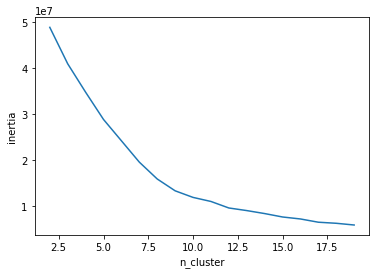

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ns, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

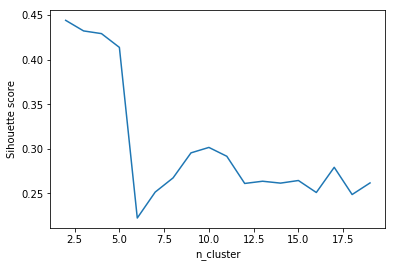

In [32]:
plt.plot(ns, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [33]:
n = 4
kmeans = KMeans(n_clusters=n, random_state=81617).fit(X_reduced_new)

In [34]:
pred_cluster = kmeans.fit_predict(X_reduced_new)

In [35]:
user_cluster = pd.DataFrame(columns=['user', 'cluster'])

In [36]:
for index, user in enumerate(user_list):
    user_cluster = user_cluster.append(pd.DataFrame([[user, pred_cluster[index]]], columns = ['user', 'cluster']))

In [37]:
user_cluster['cluster'].value_counts()

1    117
0     24
3      1
2      1
Name: cluster, dtype: int64

In [38]:
centroids = kmeans.cluster_centers_

## NMF

In [39]:
from sklearn.decomposition import NMF

In [40]:
X.shape

(143, 88311)

In [41]:
n = 8

In [42]:
nmf_model = NMF(n_components=n, init='random', random_state=818)
W = nmf_model.fit_transform(X.transpose());
H = nmf_model.components_;

In [43]:
W.shape

(88311, 8)

In [44]:
H.shape

(8, 143)

In [45]:
words_in_topics = []
for i in range(n):
    topic = W[:, i]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

['high', 'year', 'market', 'low', 'trump', 'rate', 'fed', 'bond', 'yield', 'rise']
['spy', 'post', 'new', 'market', 'spx', 'day', 'stock', 'high', 'blog', 'chart']
['gbpusd', 'eurusd', 'usdjpy', 'fx', 'audusd', 'price', 'update', 'eurgbp', 'closing', 'ftse']
['oott', 'oil', 'opec', 'saudi', 'say', 'cut', 'gold', 'min', 'week', 'qatar']
['new', 'great', 'thank', 'startup', 'good', 'company', 'business', 'today', 'entrepreneur', 'year']
['real', 'estate', 'jf', 'realestate', 'business', 'ne', 'property', 'be', 'land', 'investing']
['be', 'not', 'good', 'like', 'think', 'trump', 'day', 'time', 'know', 'thank']
['capital', 'gavekal', 'stock', 'market', 'year', 'high', 'chart', 'european', 'europe', 'knowledge']


In [46]:
print(H[:, 0])

[ 0.13572645  0.          0.00557665  0.          0.          0.01822612
  1.98215607  0.12420577]


In [52]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters , random_state=81617).fit(H.transpose())

In [53]:
pred_cluster = kmeans.fit_predict(H.transpose())

In [54]:
user_cluster = pd.DataFrame(columns=['user', 'cluster'])

In [55]:
for index, user in enumerate(user_list):
    user_cluster = user_cluster.append(pd.DataFrame([[user, pred_cluster[index]]], columns = ['user', 'cluster']))

In [56]:
user_cluster.cluster.value_counts()

4    79
0    58
3     3
1     2
2     1
Name: cluster, dtype: int64

In [57]:
centroids = kmeans.cluster_centers_

## LDA

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
X.shape

(143, 88311)

In [14]:
n_topics = 6
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=81917)

In [15]:
W = lda_model.fit_transform(X.transpose());

In [16]:
H = lda_model.components_;

In [17]:
W.shape

(88311, 6)

In [18]:
H.shape

(6, 143)

In [47]:
# ns_topics = np.arange(5, 25, 1)
# ns_clusters = np.arange(4, 15, 1)

In [ ]:
# all_inertias = []
# all_Sil_coefs = []

In [48]:
for n_topics in ns_topics:
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=81917)
    W = lda_model.fit_transform(X.transpose());
    H = lda_model.components_;
    inertias = []
    Sil_coefs = []
    for n_clusters in ns_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=81917).fit(H.transpose())
        inertias.append(kmeans.inertia_)
        labels = kmeans.labels_
        Sil_coefs.append(silhouette_score(H.transpose(), labels, metric='euclidean'))
    all_inertias.append(inertias)
    all_Sil_coefs.append(Sil_coefs)

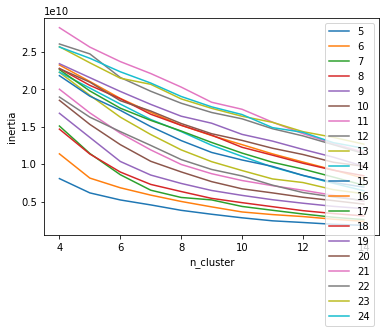

In [50]:
n = 5
for inertias in all_inertias:
    plt.plot(ns_clusters, inertias, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('inertia');

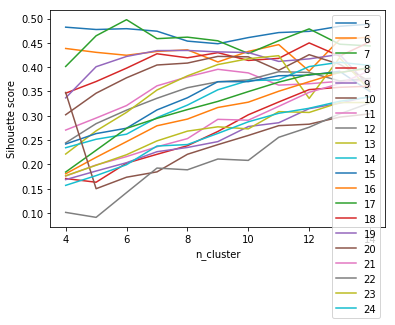

In [51]:
n = 5
for Sil_coefs in all_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [20]:
words_in_topics = []
for i in range(n_topics):
    topic = W[:, i]
    importance = -np.sort(-topic)[:20]
    word_indices = (-topic).argsort()[:20]
    print([word_list[word_index] for word_index in word_indices])
    #print(importance)
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

['oott', 'audusd', 'eurgbp', 'reinbc', 'aramco', 'apac', 'hshares', 'shale', 'igopeningcall', 'lmax', 'rba', 'gbpusd', 'pboc', 'ibex', 'kuwait', 'usdcad', 'trendingshare', 'mib', 'westpac', 'boe']
['nikeplus', 'rsd', 'feld', 'hourofcode', 'frc', 'raleigh', 'bvpfund', 'stvc', 'accel', 'ios', 'durham', 'csforall', 'browser', 'npr', 'tcdisrupt', 'bvp', 'oculus', 'dctech', 'asshole', 'vsco']
['gavekal', 'qqq', 'iwm', 'tlt', 'gld', 'es_f', 'chotd', 'mish', 'xrt', 'cmg', 'kre', 'gdx', 'wmt', 'lpladvisor', 'eem', 'slv', 'xle', 'trendlinewednesday', 'iyt', 'nq_f']
['monage', 'rns', 'blackstone', 'gratitudetrust', 'blackstonefoundation', 'macrobulletin', 'hbsltv', 'askev', 'dailyvee', 'bxq', 'schwarzman', 'nextview', 'spiritjunkie', 'ftnpod', 'polaris', 'livelifenow', 'gbpnzd', 'adis', 'quidreport', 'gbpcad']
['nvs', 'asco', 'nejm', 'rlyp', 'adcom', 'biosimilar', 'sny', 'keytruda', 'ptct', 'tsro', 'hcv', 'chmp', 'alny', 'zsph', 'pcsk', 'icpt', 'nsclc', 'rhhby', 'mdvn', 'crl']
['jf', 'landlord',

In [28]:
# topics = 10
# words_in_topics = []
# for i in range(n_topics):
#     topic = W[:, i]
#     importance = -np.sort(-topic)[:10]
#     word_indices = (-topic).argsort()[:10]
#     print([word_list[word_index] for word_index in word_indices])
#     #print(importance)
#     words_in_topics.append([word_list[word_index] for word_index in word_indices])

['robeco', 'rns', 'rtrs', 'rba', 'pboc', 'macrobulletin', 'prev', 'westpac', 'qotw', 'anz']
['frc', 'monage', 'ios', 'raleigh', 'gratitudetrust', 'stvc', 'askev', 'dailyvee', 'dctech', 'leweb']
['hsi', 'hshares', 'igopeningcall', 'lmax', 'asx', 'mish', 'trendingshare', 'gn', 'bidu', 'talkmarkets']
['blackstonefoundation', 'hbsltv', 'bxq', 'fitmob', 'blackstone', 'nextview', 'coverflow', 'volition', 'hornik', 'schwarzman']
['asco', 'nejm', 'adcom', 'biosimilar', 'keytruda', 'ptct', 'hcv', 'chmp', 'alny', 'pcsk']
['jf', 'nolan', 'glambitionradio', 'readbyrichard', 'laws', 'paydiamond', 'risingstarsa', 'lumecube', 'bestever', 'fiverr']
['imm', 'waspi', 'eiareport', 'gulfcrisis', 'eileenburbidge', 'rolfe', 'goins', 'gccpmf', 'riyadh', 'prefontaine']
['gavekal', 'chotd', 'lpladvisor', 'trendlinewednesday', 'goheel', 'darknessfall', 'enlarge', 'vxv', 'jlfmi', 'lplfocus']
['nikeplus', 'rsd', 'hourofcode', 'bvpfund', 'csforall', 'bvp', 'wdym', 'gainesville', 'adblocksummit', 'nexteconomy']
['r

In [ ]:
topic_word_user_count = []
for row in words_in_topics:
    for word in row:
        temp = {word: []}
        word_index = word_list.index(word)
        for i in range(143):
            if(X[i, word_index]) > 0:
                temp[word].append([user_list[i], X[i, word_index]])
        topic_word_user_count.append(temp)

In [70]:
# find out who has used the top words in each topic
for item in topic_word_user_count:
    print(item) 

{'robeco': [['jsblokland', 1], ['robeco', 255]]}
{'rns': [['financial_orbit', 229]]}
{'rtrs': [['5_min_macro', 1], ['amena__bakr', 1], ['chrisweston_ig', 2], ['fxcm', 34], ['igsquawk', 1], ['joelkruger', 3], ['livesquawk', 374], ['marketminute', 2], ['northmantrader', 1], ['russian_market', 8], ['samir_madani', 2], ['sassy_spy', 1], ['schuldensuehner', 10], ['sconsetcapital', 1], ['vexmark', 1], ['zerohedge', 30]]}
{'rba': [['5_min_macro', 2], ['chrisweston_ig', 52], ['faithmight', 7], ['fxcm', 34], ['igsquawk', 12], ['joelkruger', 19], ['keithmccullough', 1], ['kitjuckes', 3], ['livesquawk', 68], ['ole_s_hansen', 1], ['tihobrkan', 2], ['zerohedge', 4]]}
{'pboc': [['5_min_macro', 3], ['chrisweston_ig', 4], ['financial_orbit', 1], ['fxcm', 35], ['joelkruger', 1], ['jsblokland', 2], ['keithmccullough', 19], ['kitjuckes', 1], ['livesquawk', 89], ['schuldensuehner', 5], ['stephanie_link', 8], ['tihobrkan', 1], ['vexmark', 6], ['zerohedge', 12]]}
{'macrobulletin': [['financial_orbit', 134]]

In [ ]:
print(H[:, 0])

In [25]:
tweets_cl.find_one({'user' : 'blackstone'})['all_tweets_raw']

'$BX Agrees to Acquire Harvest Fund Advisors LLC https://t.co/3mIZGhVPp8 READ: Tony James discusses philanthropy, civic engagement and Montana on the @Blackstone blog https://t.co/2A5KZpyurD https://t.co/7KKmV4FChm $BX CEO Steve Schwarzman to the incoming class of analysts, “you build a foundation of skills for yourself through asking questions” https://t.co/nDX4TmbSXk In 2011, $BX began to invest in India #CRE. See how we became the largest owner of office parks in the country: https://t.co/2LTycQMr8j In the 1st edition of @Work_Bench’s CxO corner, $BX CTO Bill Murphy shares his views on emerging tech. Read more https://t.co/vE2HGuggC6 https://t.co/ObV9ssfnFQ .@Cloudreach and @Cloudamize join forces to accelerate intelligent cloud adoption in Blackstone-backed merger. MORE: https://t.co/qukGRZvZfP RT @BlackstoneEI: What are the key tenets to successful entrepreneurial partnerships? @BlackstoneEI shares insights from #ESHIPSummit https… Hello from the Buy Side: $BX portfolio company SE

In [19]:
tweets_cl.find_one({'user' : 'financial_orbit'})['all_tweets_clean'][:1000]

'Let\'s hope Janet Y is aware of some of this data! I doubt if we see a Presidential tweet on this! Financial Orbit Macro is a one-stop #macrobulletin compiled in a manic fashion each morning from a range of sources. Named by MarketWatch as one of the fifty Twitter accounts for investors to follow in #. Follow me so I can pass on some of my knowledge I am a sucker for a bit of cod philosophy and venn diagrams A new word to periodically use! (obviously) Guilty on all counts "Human beings says Fischer borrowing from Milton Friedman aren\'t rational but they\'re great at rationalising things" Want know more about the #world? Get my daily global macro briefing to your inbox by subscribing here Very good wordplay! Just don\'t lose the bikes! Don\'t panic IMO "Emerging market stock funds suffered $.bn withdrawals in week to August  largest weekly outflow since last December" Oh Donald...if only you hadn\'t hacked off Angela M you could have formed a united front. As it is #BeltandRoad will b

In [20]:
tweets_cl.find_one({'user' : 'financial_orbit'})['bag_of_words'][:1000]

"let 's hope janet y aware datum doubt presidential tweet financial orbit macro stop macrobulletin compile manic fashion morning range source name marketwatch twitter account investor follow follow pass knowledge sucker bit cod philosophy venn diagram new word periodically use obviously guilty count human being say fischer borrowing milton friedman not rational be great rationalise thing want know world daily global macro briefing inbox subscribe good wordplay not lose bike not panic imo emerge market stock fund suffer $ .bn withdrawal week august large weekly outflow december oh donald not hack angela m form united beltandroad lure be chance lose lot money smart beta quant fund great chance win lottery technical ok obs lack savings crisis yes research question image spendthrift uk consumer long term liability doubt itv ytd low likely content monetisation eyeball fear apparently s&p close -week low bannon fade noise eh deep summer august friday want know make tick successful global inv

In [ ]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters , random_state=81617).fit(H.transpose())

In [ ]:
pred_cluster = kmeans.fit_predict(H.transpose())

In [ ]:
user_cluster = pd.DataFrame(columns=['user', 'cluster'])

In [ ]:
for index, user in enumerate(user_list):
    user_cluster = user_cluster.append(pd.DataFrame([[user, pred_cluster[index]]], columns = ['user', 'cluster']))

In [ ]:
user_cluster.cluster.value_counts()

In [ ]:
centroids = kmeans.cluster_centers_